<a href="https://colab.research.google.com/github/LohitSubodh/Machine-Learning/blob/master/LOHIT_SUBODH_lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#                                               Lab 1 - Weightage - 3%

##  Decision Trees and Random Forests



### Dataset used : Amazon Fine food reviews.
### Maximum points in lab : 75 pts.
#### Important points to remember :
 1. Observations for the experiments done should be explained.
 2. All the code should be submitted in form of single Jupyter notebook itself.
 3. Points for each sub-section are mentioned in appropriate question.
 4. Make sure to begin early since few experiments may consume more time to run.
 5. You can use Google colab to run in jupyter notebook (https://colab.research.google.com/) How to load data in Google Colab ?(https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92)
 6. The lab must be submitted on Google classroom. The code as well as the accompanying observations should be made part of the python notebook.
 7. __The lab is due on Feb 7th 11.59pm.__
 8. __The lab should be completed individually. Students are expected to follow the honor code of the class.__

### 1. Go through [scikit learn DecisionTree documentation] : https://scikitlearn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
### Explain briefly various options available in corresponding DecisionTree classifier in scikit-learn package. [5 pts]




1. **criterion** :{“gini”, “entropy”}, default=”gini”
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
2. **splitter** :{“best”, “random”}, default=”best”
The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.
3. **max_depth** :int,default=None
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
4. **min_samples_split** :int or float, default=2
The minimum number of samples required to split an internal node:
If int, then consider min_samples_split as the minimum number.
If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.
5. **min_samples_leaf** :int or float, default=1
The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.

# Add your description of the function here.

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5 
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

Out of above attributes we will consider <strong>Score as Y or Output variable</strong>, and  <strong>Summary as X or data points.</strong>



### Import Libraries

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn import model_selection
import pickle
import sqlite3
import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

### 2.  Dataset loading, train test split, print two data points after converting score column into positive, negative class - [5 pts]
#### steps :
 Use score column as the output variable and Summary as the input variable
 1. Convert score column as score > 3 - positive class and score <=3 as negative class.
 2. Now define train test split as 0.25.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# connecting to the dataset server to download the amazon fine foods dataset. Do not make any changes to the code below
con = sqlite3.connect('/content/drive/My Drive/amazon-fine-food-reviews/database.sqlite')
messages = pd.read_sql_query("""
SELECT Score, Summary
FROM Reviews
""", con)

# the parition function applied threshold on the rating to label a review as 'positive' or 'negative'.
def partition(x):
    if x>3:
      return 1
    return 0

Score = messages['Score']
Score = Score.map(partition)
Summary = messages['Summary']

# call the function to create the train and test splits according to the ratio 75:25
# uncomment and complete the line below

train_X, test_X, train_y, test_y = train_test_split(Summary,Score,test_size=0.25)
print(train_X)

# print an example of the dataset after the labeling process
print(messages.head(2))
tmp = messages
tmp['Score'] = tmp['Score'].map(partition)
print(tmp.head(2))

442903                                      cat food
530976               Great value for my favorite tea
48265                   DOT BUY PLASTIC BOTTLED ZICO
34819                            Very strange flavor
216712                               EasyMac is easy
                             ...                    
29717                                   Tea Purchase
434312    I dont even like flavored coffee, but.....
47519        Love it so much that I subscribe to it.
198397                        I liked it at first...
444034                            My dog loved them!
Name: Summary, Length: 426340, dtype: object
   Score                Summary
0      5  Good Quality Dog Food
1      1      Not as Advertised
   Score                Summary
0      1  Good Quality Dog Food
1      0      Not as Advertised


In [0]:
# do not change make any changes to the code below. This part of the
# code removes stop words and transforms all the words and letters
# into a uniform representation. Further, it also removes punctuation
# marks.
nltk.download('punkt')
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

corpus = []
count_train_x=0
for text in train_X:
    count_train_x=count_train_x+1
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    corpus.append(text)
        
count_test_x=0
test_set=[]
for text in test_X:
    count_test_x=count_test_x+1
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    test_set.append(text)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(corpus)        
X_test_counts = count_vect.transform(test_set)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### 4. Print before and after using data pre-processing for five data points - [5 pts]
For example, following are some outputs that we were able to generate

 ID | Before preprocessing | After preprocessing 
 -|-|-
 45612 | Good Strong Flavor|good strong flavor 
 180139 | GREAT SIDE DISH | great side dish 
 541273 | Its agar | it agar 
 102774 | Great product! | great product
 447382 | Love them | love them 

In [0]:
# Data before the processing step is stored in the variable train_X 
# and the processed data is present in corpus. Print randomly 5 
# instances to check the success of the processing step. 
# insert your code here
    for i in range(0,5) :
      print(train_X.iloc[[i]].to_string(),corpus[i])

442903    cat food cat food
530976    Great value for my favorite tea great valu for my favorit tea
48265    DOT BUY PLASTIC BOTTLED ZICO dot buy plastic bottl zico
34819    Very strange flavor veri strang flavor
216712    EasyMac is easy easymac is easi


### 5. Build a basic decision tree choosing appropriate min_samples_leaf parameter so that tree fits in output cell using Graphviz package [5 pts]
Use the decision tree classifier from the sklearn library to learn a decision tree from the training dataet. For now, we would like to only visualize the tree to ensure that we are calling the correct function. Set the min_samples_leaf parameter to a high value (>15000) for learning the tree. This tree will not be accurate, but will be big enough for us to visualize it. Identify the functions in the tree package that will help to visualize the tree and plot it. Below is a sample tree generated when mi_samples_leaf was set to 20000
![tree.png](attachment:tree.png)

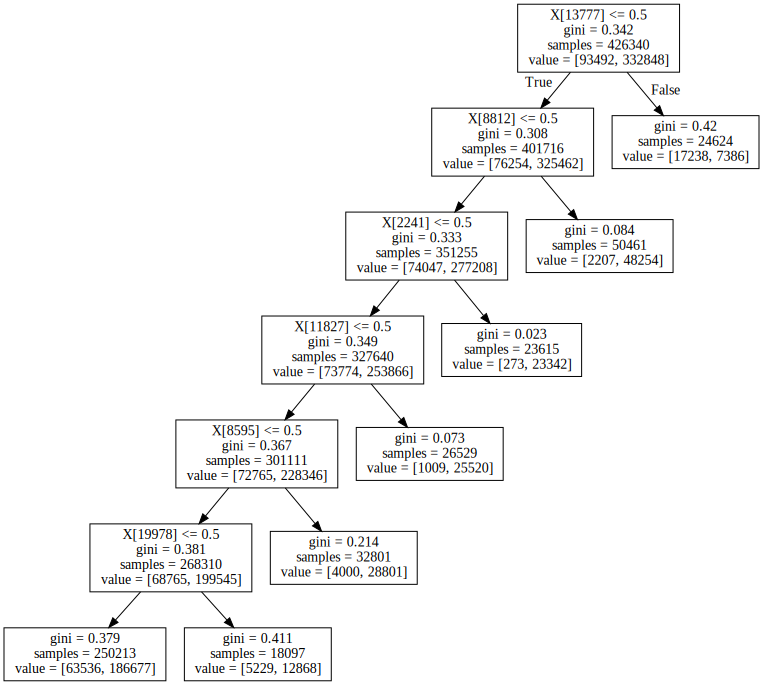

In [0]:
from sklearn import tree
import graphviz
from sklearn.tree import DecisionTreeClassifier
obj=DecisionTreeClassifier(min_samples_leaf=18000)
obj=obj.fit(X_train_counts,train_y)
graph=tree.export_graphviz(obj)
graphviz.Source(graph)

### 6. Experiments with different tree parameters
#### a. minimum number of samples in a node.  [5 pts]
By now we should have all the code in place for learning accurate decision trees. As we discussed in the class, one method to prevent overfitting a decision tree is to put constraints on the number of samples assigned to a split node during training. We had used this parameter to learn extremely short decision trees in the previous step. Let us now vary this parameter and investigate the impact on the train and test accuracy of the model. 
The first part of the code should loop around different values for min_samples_split and save the resulting train and test accuracy. In the second part, plot a graph with x-axis being the number of samples in the node and accuracy being the y axis. Plot both the train and test accuracies in the same figure. Write a generic function for the plotting as we will use it later for other visualizations.

In [0]:
from sklearn import tree
import graphviz
from sklearn.tree import DecisionTreeClassifier
test_accuracy_list=[]
train_accuracy_list=[]
min_samples_split = [10,50,100,200]
for i in min_samples_split:
    claf=DecisionTreeClassifier(min_samples_split=i)
    claf.fit(X_train_counts,train_y)
    train_accuracy_list.append(claf.score(X_train_counts,train_y))
    test_accuracy_list.append(claf.score(X_test_counts,test_y))
    




[0.916503651997692, 0.9114232236092151, 0.9075882742024008, 0.9038940568839101] [0.9711380588262889, 0.9527841628747009, 0.943308157808322, 0.9332950227517943]


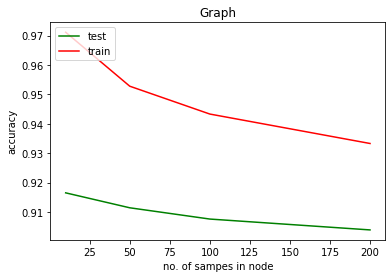

In [0]:
def plot_accuracy(test_accuracy_list,train_accuracy_list,nodes_list, xlabel, ylabel, title):
    plt.plot(nodes_list,test_accuracy_list,'g',label="test")
    plt.plot(nodes_list,train_accuracy_list,'r',label="train")
    plt.legend(loc="upper left")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
print(test_accuracy_list,train_accuracy_list)
plot_accuracy(test_accuracy_list,train_accuracy_list,min_samples_split,"no. of sampes in node","accuracy","Graph")

#### b. maximum number of leaf nodes in the tree [5 pts]
The tree learner has a parameter max_leaf_nodes. Discuss the role of this parameter during the tree learning. Investigate the impact of this parameter on the train and test accuracy.

 **max_leaf_nodes** :int, default=None Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

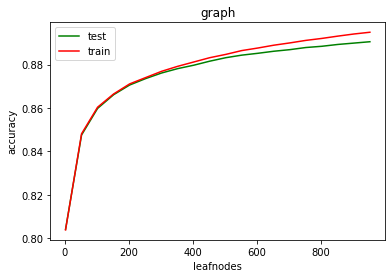

In [0]:
test_accuracy_list=[]
train_accuracy_list=[]
node=[]
max_leaf_nodes=1000
step_size_2=50
for i in range(2, max_leaf_nodes,step_size_2):
    node.append(i)
    claf=DecisionTreeClassifier(max_leaf_nodes=i)
    claf.fit(X_train_counts,train_y)
    train_accuracy_list.append(claf.score(X_train_counts,train_y))
    test_accuracy_list.append(claf.score(X_test_counts,test_y))

plot_accuracy(test_accuracy_list, train_accuracy_list,node, "leafnodes", "accuracy", "graph")

#### c. splitting criteria [5 pts]
Identify the default splitting critera and experiment with other criterion implemented in the tree package. Report the accuracy on the test dataset as well as other parameters chracterizing the learned decision tree. 

In [0]:
# insert your code here
    print("default splitting criterion is gini")
    claf=DecisionTreeClassifier()
    claf.fit(X_train_counts,train_y)
    print("training accuracy for gini: ",claf.score(X_train_counts,train_y))
    print("test accuracy for gini: ",claf.score(X_test_counts,test_y))
    claf=DecisionTreeClassifier(criterion="entropy")
    claf.fit(X_train_counts,train_y)
    print("training accuracy for entropy: ",claf.score(X_train_counts,train_y))
    print("test accuracy for entropy: ",claf.score(X_test_counts,test_y))

default splitting criterion is gini
training accuracy for gini:  0.9852230614063893
test accuracy for gini:  0.9131049720646804
training accuracy for entropy:  0.9852230614063893
test accuracy for entropy:  0.9143363778375108


The default splitting criterion is "gini" for Gini impurity.

#### d. depth of the decision tree [5 pts]
Investigate the impact of depth of the decision tree on the test accuracy

In [0]:
test_accuracy_list=[]
train_accuracy_list=[]
node=[]
maximum_depth=1000
step_size=50
for i in range(1, maximum_depth,step_size):
    #insert your code here
    node.append(i)
    claf=DecisionTreeClassifier(max_depth=i)
    claf.fit(X_train_counts,train_y)
    train_accuracy_list.append(claf.score(X_train_counts,train_y))
    test_accuracy_list.append(claf.score(X_test_counts,test_y))




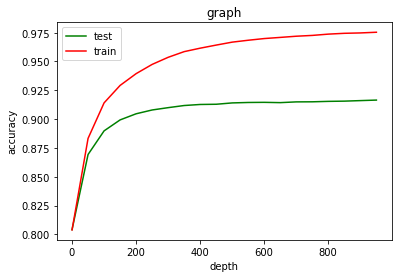

In [0]:
plot_accuracy(test_accuracy_list, train_accuracy_list,node, "depth", "accuracy", "graph")

### 7. Random forest
Now, let us explore an ensemble of decision trees - random forest. Fortunately, sklearn has an ensemble library containing the random forest classifier. Let us learn a random forest using both instance and feature bagging independently.
#### a. briefly describe the input parameters to the random forest classifier [5 pts]
insert your description here
1. **n_estimators** :integer, optional (default=100)
The number of trees in the forest.
2.  **criterion** :string, optional (default=”gini”)
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
3. **max_depth** : integer or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
4. **min_samples_split** :int, float, optional (default=2)
The minimum number of samples required to split an internal node.
5. **n_jobs** : int or None, optional (default=None)
The number of jobs to run in parallel.
6. **max_features** :int, float, string or None, optional (default=”auto”)
The number of features to consider when looking for the best split:

#### b. instance bagging [10 pts]
As discussed in the class, instances are sampled with replacement to create multiple synthetic training sets. Decision tree is learned for every training set. An ensemble strategy (majority voting) is applied on the output of all the trees for a test instance. Let us vary the number of instances in each bag to learn the random forest and check if there is impact on the performance of the ensemble. 

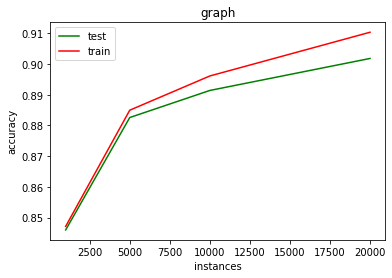

In [0]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
import random
test_accuracy_list=[]
train_accuracy_list=[]
number_of_instances = [1000,5000,10000,20000]
for i in number_of_instances:
    claf=RandomForestClassifier(max_samples=i,n_jobs=-1)
    claf.fit(X_train_counts,train_y)
    train_accuracy_list.append(claf.score(X_train_counts,train_y))
    test_accuracy_list.append(claf.score(X_test_counts,test_y))

plot_accuracy(test_accuracy_list, train_accuracy_list,number_of_instances ,"instances", "accuracy", "graph")

#### c. feature bagging [10 pts]
For performing feature bagging, we sample a subset of features from the initial set of features. A decision tree is learned for every training set that contains all the instances characterized by a subset of features. An ensemble strategy is applied for classifying a test instance. In this experiment we will investigate the impact of varying the number of features bagged on the test accuracy.

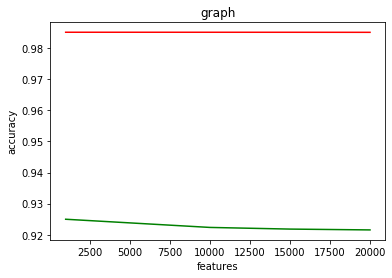

In [0]:
test_accuracy_list=[]
train_accuracy_list=[]
number_of_features = [1000,10000,15000,20000]
for i in number_of_features:
    claf=RandomForestClassifier(max_features=i,n_jobs=-1)
    claf.fit(X_train_counts,train_y)
    train_accuracy_list.append(claf.score(X_train_counts,train_y))
    test_accuracy_list.append(claf.score(X_test_counts,test_y))

    
plot_accuracy(test_accuracy_list ,train_accuracy_list,number_of_features, "features", "accuracy", "graph")

train accuracy -red test accuracy -green

#### d. number of trees in the forest [10 pts]
Finally let us vary the number of trees in the random forest. We will use the default random forest classifier and only vary the number of trees learned in the ensemble. Again make your observations on the test accuracy as the number of trees are varied.

In [0]:
def plot_accuracy(test_accuracy_list,train_accuracy_list,nodes_list, xlabel, ylabel, title):
  import sklearn    
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import random
test_accuracy_list=[]
train_accuracy_list=[]
number_of_trees = [1,2,5,10,50]
for i in number_of_trees:
    claf=RandomForestClassifier(n_estimators=i,n_jobs=-1)
    claf.fit(X_train_counts,train_y)
    train_accuracy_list.append(claf.score(X_train_counts,train_y))
    test_accuracy_list.append(claf.score(X_test_counts,test_y))

    


In [0]:
def plot_accuracy(test_accuracy_list,train_accuracy_list,nodes_list, xlabel, ylabel, title):
    plt.plot(nodes_list,test_accuracy_list,'g',label="test")
    plt.plot(nodes_list,train_accuracy_list,'r',label="train")
    plt.legend(loc="upper left")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

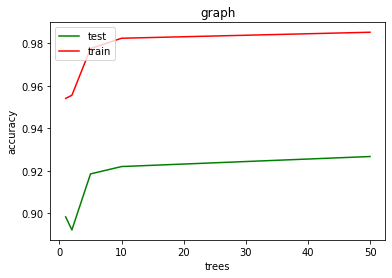

In [0]:
plot_accuracy(test_accuracy_list ,train_accuracy_list,number_of_trees, "trees", "accuracy", "graph")